# Importing Libraries

---





In [1]:
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
import seaborn as sns

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Loading Dataset

---





In [0]:
data=pd.read_csv('/content/drive/My Drive/ZS/data.csv', index_col = 0)
sample=pd.read_csv('/content/drive/My Drive/ZS/sample_submission.csv')

In [3]:
data.head()

,match_event_id,location_x,location_y,remaining_min,power_of_shot,knockout_match,game_season,remaining_sec,distance_of_shot,is_goal,area_of_shot,shot_basics,range_of_shot,team_name,date_of_game,home/away,shot_id_number,lat/lng,type_of_shot,type_of_combined_shot,match_id,team_id,remaining_min.1,power_of_shot.1,knockout_match.1,remaining_sec.1,distance_of_shot.1
0,10.0,167.0,72.0,10.0,1.0,0.0,2000-01,27.0,38.0,NaN,Right Side(R),Mid Range,16-24 ft.,Manchester United,2000-10-31,MANU @ POR,1.0,"45.539131, -122.651648",shot - 30,NaN,20000012,1610612747,10.00,1.0,50.608,54.2000,38.0
1,12.0,-157.0,0.0,10.0,1.0,0.0,2000-01,22.0,35.0,0.0,Left Side(L),Mid Range,8-16 ft.,Manchester United,2000-10-31,MANU @ POR,2.0,"45.539131, -122.651648",shot - 45,NaN,20000012,1610612747,10.00,1.0,28.800,22.0000,35.0
2,35.0,-101.0,135.0,7.0,1.0,0.0,2000-01,45.0,36.0,1.0,Left Side Center(LC),Mid Range,16-24 ft.,Manchester United,2000-10-31,NaN,3.0,"45.539131, -122.651648",shot - 25,NaN,20000012,1610612747,92.64,1.0,0.000,63.7216,54.4
3,43.0,138.0,175.0,6.0,1.0,0.0,2000-01,52.0,42.0,0.0,Right Side Center(RC),Mid Range,16-24 ft.,Manchester United,2000-10-31,MANU @ POR,4.0,"45.539131, -122.651648",NaN,shot - 3,20000012,1610612747,NaN,1.0,122.608,52.0000,42.0
4,155.0,0.0,0.0,NaN,2.0,0.0,2000-01,19.0,20.0,1.0,Center(C),Goal Area,Less Than 8 ft.,NaN,2000-10-31,MANU @ POR,5.0,"45.539131, -122.651648",NaN,shot - 1,20000012,1610612747,42.64,2.0,0.000,19.0000,20.0


In [4]:
sample.head()

,shot_id_number,is_goal
0,1,0.1
1,8,0.1
2,17,0.1
3,20,0.1
4,33,0.1


In [5]:
print('Test Data Length:', len(sample)) # Test Data Size
print('Input Data Lenght:', len(data))  # Input Size = Number of Tuples
print('Input Columns Length:', len(data.columns)) # Number of columns in data
print('Columns:', data.columns) 

Test Data Length: 5000
Input Data Lenght: 30697
Input Columns Length: 27
Columns: Index(['match_event_id', 'location_x', 'location_y', 'remaining_min',
       'power_of_shot', 'knockout_match', 'game_season', 'remaining_sec',
       'distance_of_shot', 'is_goal', 'area_of_shot', 'shot_basics',
       'range_of_shot', 'team_name', 'date_of_game', 'home/away',
       'shot_id_number', 'lat/lng', 'type_of_shot', 'type_of_combined_shot',
       'match_id', 'team_id', 'remaining_min.1', 'power_of_shot.1',
       'knockout_match.1', 'remaining_sec.1', 'distance_of_shot.1'],
      dtype='object')


# Preprocessing 


---


## A. Removing Nans to nearby values, Converting Labels to Categorical Numerical Values 


---





### A.1: Function to Encode Categorical Variables into float values

---




In [0]:
def categorical_encoder(col,data):
  """
    Parameters
    ----------
    col : Name of the column of dataset that you want to encode into categorical float values
    data  : The input dataframe that needs to be processed

    Returns 
    ----------
    Updated Dataframe
    
  """  
  # Take input data in temp variable  
  temp_data = data

  # Create a label (category) encoder object
  le = preprocessing.LabelEncoder()

  # Fit the encoder to the pandas column and convert column type to string type
  temp_data[col] = temp_data[col].astype('|S80') 
  le.fit(temp_data[col])
  
  # View the labels (if you want)
  # print(list(le.classes_))

  # Apply the fitted encoder to the pandas column
  temp_data[col] = (le.transform(data[col])).astype('float64')
  
  return temp_data
    

# See the data type of each column

---





In [7]:
for i in range(len(data.columns)):
    print(data.columns[i],':', data[data.columns[i]].dtype)

match_event_id : float64
location_x : float64
location_y : float64
remaining_min : float64
power_of_shot : float64
knockout_match : float64
game_season : object
remaining_sec : float64
distance_of_shot : float64
is_goal : float64
area_of_shot : object
shot_basics : object
range_of_shot : object
team_name : object
date_of_game : object
home/away : object
shot_id_number : float64
lat/lng : object
type_of_shot : object
type_of_combined_shot : object
match_id : int64
team_id : int64
remaining_min.1 : float64
power_of_shot.1 : float64
knockout_match.1 : float64
remaining_sec.1 : float64
distance_of_shot.1 : float64


In [0]:
def preprocess_train(data):
 
  """
    Parameters
    ----------
    data  : The input dataframe that needs to be processed

    Returns 
    ----------
    Updated Dataframe
    
  """
  temp_data = data

  """
  Steps: 
  1. Convert home/away to 0.8 for in home, 0.2 for out of home matches, 0 for Nan
  2. Combine columns 'type_of_shot', 'type_of_combined_shot' to one column
  3. Drop useless columns
  4. Convert categorical attributes to numerical values
  5. Find X and Y for fitting model
  """

  l=[]
  for i in range(len(temp_data)):
    if math.isnan(temp_data['is_goal'].iloc[i]) :
        l.append(i) # Append all indexes to list where goal is 'nan' 
  # Step 1: 
  # Declare temporary dataframe
  df1=pd.DataFrame(columns=['home/away'])
  df1['home/away']=temp_data['home/away']    
  df1=df1.fillna('') # Fill nan with space

  # '@' implies away from home country
  # 'VS' implies match is in home country
  
  for i in range(len(df1)):

    if '@' in df1.iloc[i][0]:
      df1.iloc[i][0] = 0.2 # Assuming it's value to be low because less chances of winning match in other country 

    elif 'vs' in df1.iloc[i][0]:
      df1.iloc[i][0] = 0.8 # Assuming it's value to be low because more chances of winning match in home country

    else:
      df1.iloc[i][0] = 0  # For Nan, Assuming to be 0 

 
  df1['home/away'] = df1['home/away'].astype(np.float64)   
  temp_data['home/away'] = df1['home/away'] # Overwrite 'Home/Away' column to original data by updating values

  # Step 2:     
  # Declare another temporary Dataframe for combining below 2 columns by summing them    
  df2=pd.DataFrame(columns = ['type_of_shot','type_of_combined_shot'])

  df2['type_of_shot'] = temp_data['type_of_shot']
  df2['type_of_combined_shot'] = data['type_of_combined_shot']
  df2['a+b'] = df1.fillna('').sum(axis=1) 
  temp_data['type_of_shot'] = df2['a+b'] # Appending summed string values of both columns
  temp_data=temp_data.drop(columns = ['type_of_combined_shot']) # drop 1 column
        
   
  # Drop rows where value of 'is_goal' is 'nan'      
  train_data=temp_data.drop(index = l) 
  
  # Step 3: 
  # Drop useless attributes  
  #train_data=train_data.drop(columns = ['shot_id_number','match_event_id','game_season','team_name','date_of_game','lat/lng','match_id','team_id','knockout_match','knockout_match.1'])
  train_data=train_data.drop(columns = ['shot_id_number','match_event_id','game_season','team_name','date_of_game','match_id','team_id'])
  #train_data=train_data.drop(columns = ['shot_id_number','match_event_id','game_season','team_name','date_of_game','match_id','team_id',
  #'location_y', 'distance_of_shot', 'remaining_min.1', 'power_of_shot.1', 'remaining_sec.1', 'distance_of_shot.1', 'knockout_match.1'])
  # Step 4:
  # Find which attribute dtype = 'object' || 'string' -> Convert them using label encoder 
  encode_attributes = []
  for i in train_data.columns:
    if(train_data[i].dtype == 'object'):
      encode_attributes.append(i)
  
  print('Attributes to be encoded:',encode_attributes)
  
  for col in encode_attributes:
    categorical_encoder(col,train_data)
  
  #print(train_data.iloc[0])

  # Step 5: 
  # Determine X and Y for fitting the model
  train_data = train_data.fillna(0) # Fill na with 0
  X_df = train_data.drop(columns = ['is_goal']) # Drop useless columns 
  X = X_df.as_matrix()
  Y = train_data['is_goal']
  X = preprocessing.scale(X) # Normalizes X column wise X = (X-mean)/sigma
  return X,Y,X_df.columns, train_data

In [9]:
data=pd.read_csv('/content/drive/My Drive/ZS/data.csv', index_col = 0)
X, Y, X_columns, train_data = preprocess_train(data)

Attributes to be encoded: ['area_of_shot', 'shot_basics', 'range_of_shot', 'lat/lng']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [10]:
X.shape, Y.shape, X_columns

((24429, 18),
 (24429,),
 Index(['location_x', 'location_y', 'remaining_min', 'power_of_shot',
        'knockout_match', 'remaining_sec', 'distance_of_shot', 'area_of_shot',
        'shot_basics', 'range_of_shot', 'home/away', 'lat/lng', 'type_of_shot',
        'remaining_min.1', 'power_of_shot.1', 'knockout_match.1',
        'remaining_sec.1', 'distance_of_shot.1'],
       dtype='object'))

# Histogram Visualization of Dataset

---







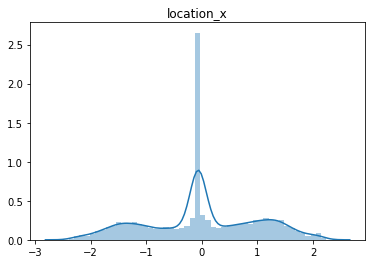

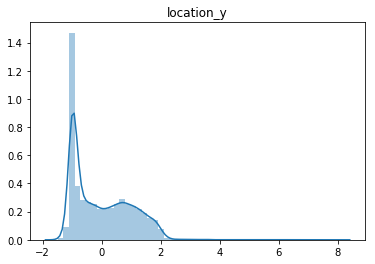

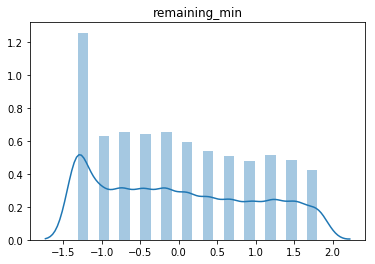

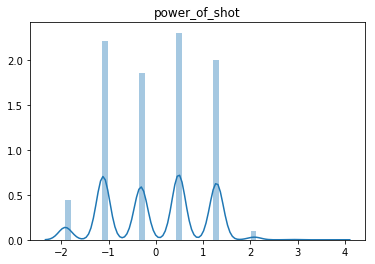

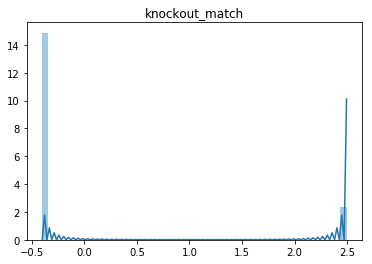

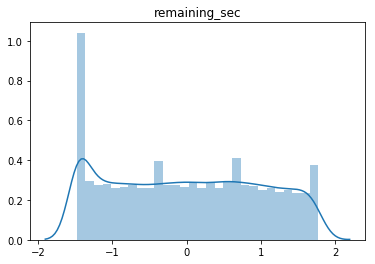

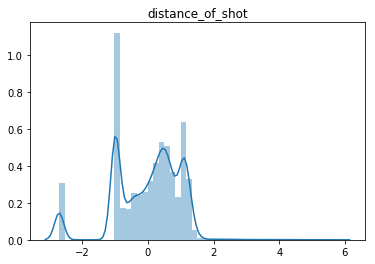

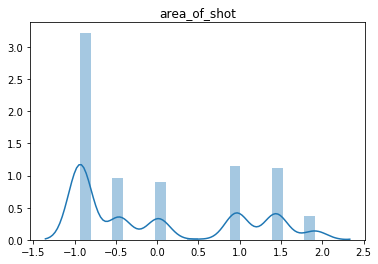

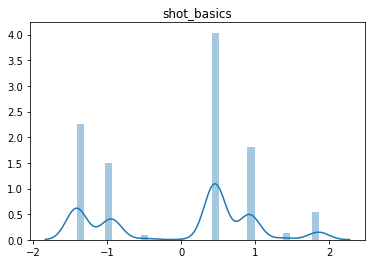

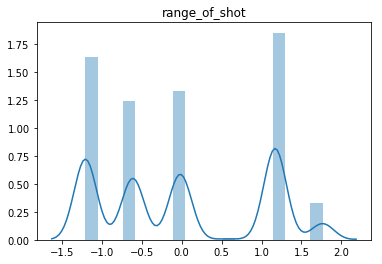

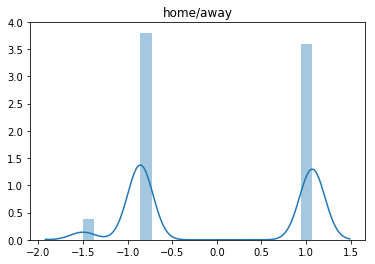

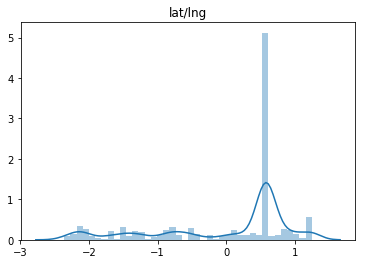

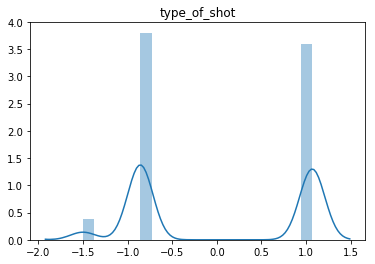

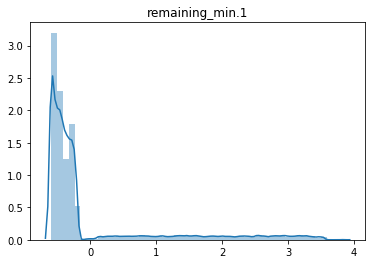

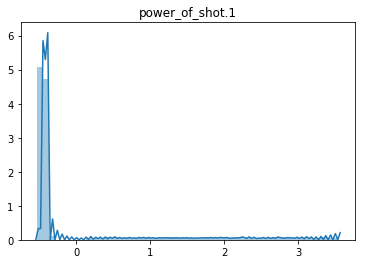

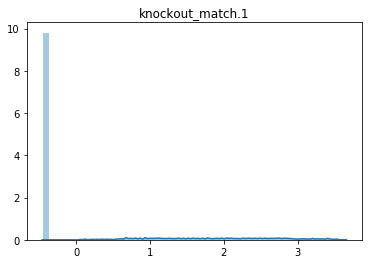

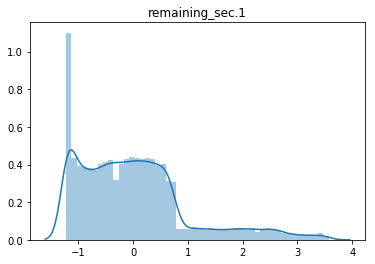

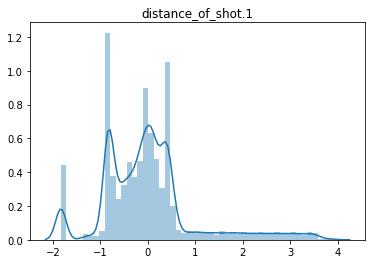

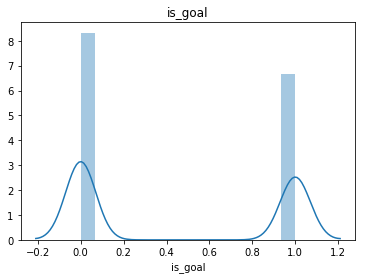

In [11]:
for i in range(X.shape[1]):
    plt.figure()
    plt.title(X_columns[i])
    sns.distplot(X[:,i]) # Also plots Gaussian KDE over data
plt.figure()
plt.title('is_goal')
sns.distplot(Y)  

### We can see that perhaps the attributes 'location_y', 'remaining_min_1','remaining_sec' may have an exponential distribution.

---
 ### We can also see that perhaps 'location_x', 'power_of_shot_1' attributes may have a Gaussian or nearly Gaussian distribution. 


---


### This is interesting because many machine learning techniques assume a Gaussian univariate distribution on the input variables.

In [12]:
print(X_columns)
print(len(X_columns))

Index(['location_x', 'location_y', 'remaining_min', 'power_of_shot',
       'knockout_match', 'remaining_sec', 'distance_of_shot', 'area_of_shot',
       'shot_basics', 'range_of_shot', 'home/away', 'lat/lng', 'type_of_shot',
       'remaining_min.1', 'power_of_shot.1', 'knockout_match.1',
       'remaining_sec.1', 'distance_of_shot.1'],
      dtype='object')
18


In [13]:
print(len(train_data.columns))
print(train_data.shape)
train_data.head()

19
(24429, 19)


,location_x,location_y,remaining_min,power_of_shot,knockout_match,remaining_sec,distance_of_shot,is_goal,area_of_shot,shot_basics,range_of_shot,home/away,lat/lng,type_of_shot,remaining_min.1,power_of_shot.1,knockout_match.1,remaining_sec.1,distance_of_shot.1
1,-157.0,0.0,10.0,1.0,0.0,22.0,35.0,0.0,2.0,4.0,2.0,0.2,34.0,0.2,10.00,1.0,28.800,22.0000,35.0
2,-101.0,135.0,7.0,1.0,0.0,45.0,36.0,1.0,1.0,4.0,0.0,0.0,34.0,0.0,92.64,1.0,0.000,63.7216,54.4
3,138.0,175.0,6.0,1.0,0.0,52.0,42.0,0.0,4.0,4.0,0.0,0.2,34.0,0.2,0.00,1.0,122.608,52.0000,42.0
4,0.0,0.0,0.0,2.0,0.0,19.0,20.0,1.0,0.0,0.0,4.0,0.2,34.0,0.2,42.64,2.0,0.000,19.0000,20.0
5,-145.0,-11.0,9.0,3.0,0.0,32.0,34.0,0.0,2.0,4.0,2.0,0.2,34.0,0.2,9.00,3.0,0.000,0.0000,34.0


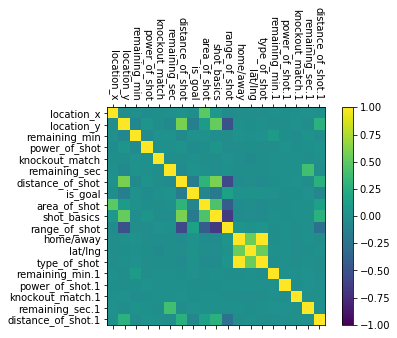

<Figure size 1440x1080 with 0 Axes>

In [14]:
correlations = train_data.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,19,1)
#ticks = np.arange(0,12,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(train_data.columns, rotation = -90)
ax.set_yticklabels(train_data.columns)
plt.figure(figsize=(20,15))
plt.show()


In [15]:
correlations.shape

(19, 19)

# Any Multicollinearity? 

## Multicorrelated variables tend to disturb the model learning in linear regression
## Not Harmful for model as variance_inflation_factor < 10, shown in linear regression model 
---


## 1. See Blue and green patches - Is that a problem?


---


### A. 'shot_basics' and 'range_of_shot' are highly correlated
### B. 'area_of_shot' and 'range_of_shot' are also highly correlated
### C. 'range_of_shot' and 'distance_of_shot' are correlated
### D. 'range_of_shot' and 'location_y' are also correlated


---


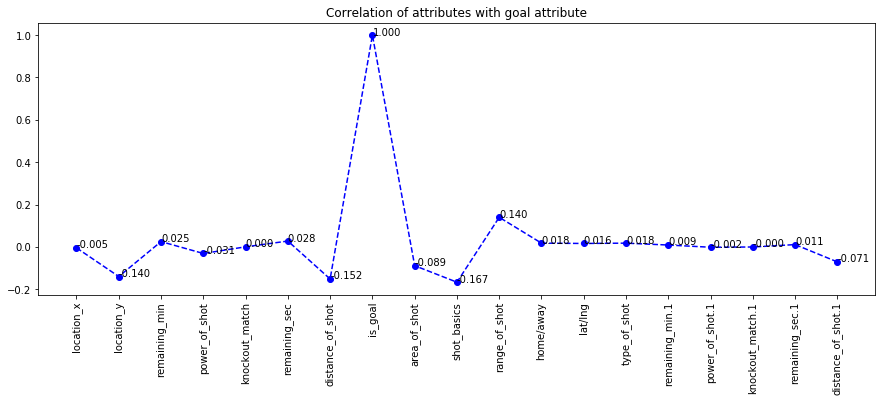

In [16]:
corr_list = []
corr_with_label = []
for i in range(correlations.shape[0]):
    j = 7
    corr_list.append(correlations.iloc[i][j])
    corr_with_label.append((train_data.columns[i], correlations.iloc[i][j]))
x = train_data.columns
y = corr_list
fig, ax = plt.subplots(figsize=(15,5 ))
plt.plot(x,y,'--bo')
for i,j in zip(x,y):
    ax.annotate(str("{0:.3f}".format(j)),xy=(i,j))
plt.xticks(rotation=90)
plt.title('Correlation of attributes with goal attribute')

plt.show()

# Observation: 

---


## 1. The range of correlations among all attributes is between -0.2 to 0.2. Thus almost all attributes are nearly uncorrelated with the goal attribute.

---
## 2. A correlation of 0 doesn't imply that attributes are independent of the attribure 'is_goal'
## 3. Which model would perform better? 

---











# Box plots to find out presence of Outliers

---



Text(0.5, 1.0, 'BOX PLOT')

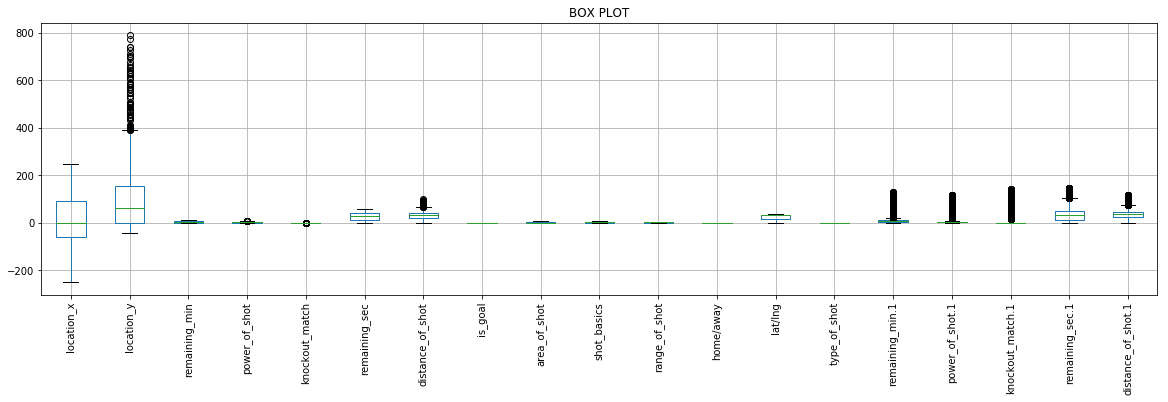

In [17]:
train_data.boxplot(figsize = (20,5))
plt.xticks(rotation = 90)
plt.title('BOX PLOT')

# Observation: 
## 1. As we can see, 'location_y', 'distance_of_shot', 'remaining_min.1', 'power_of_shot.1', 'remaining_sec.1', 'distance_of_shot.1' have outliers which may confuse regression models. 

# Let's fit classifiers
## 1. Linear Regression
## 2. SVM
## 3. KNN
## 4. Decision Tree
## 5. Random Forest
## 6. XGboost
## 7. ANN

# Train:Test Split

In [0]:
from sklearn import metrics 
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1) 

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19543, 18), (4886, 18), (19543,), (4886,))

In [20]:
X.shape

(24429, 18)

## 1. Linear Regression

In [21]:
from sklearn import linear_model
# create linear regression object 
reg = linear_model.LinearRegression()

#reg = linear_model.Ridge()   # Regulizer to prevent overfitting if any # Extra term (lambda * ((Slope)^2 + (Attr1)^2+ Attr2^2 +......) is used in loss function
# lambda is determined using cross validation
# Introduces Bias in model which reduces variance and hence be a good option to prevent overfitting
# train the model using the training sets 
reg.fit(X_train, y_train) 

y_pred = reg.predict(X_test)


mse(y_test, y_pred)

0.23840389087847913

## To prove that multi-collinearity is not harmful for model
## If VIF>10, then it's a serious problem

In [22]:
r_square = reg.score(X_train,y_train)
VIF = 1/(1-r_square)
r_square, VIF

(0.03610964714147735, 1.0374624012310012)

In [23]:
vif = []
for i in range(X.shape[1]):
    col = {j for j in range(0,X.shape[1])}
    col = col - {i}
    X_new = np.zeros(shape = (X.shape[0],X.shape[1]-1))
    y_new = X[:,i]
    p = 0
    for k in col:
        X_new[:,p] = X[:,k]
        p = p+1
    reg.fit(X_new, y_new)
    r_square = reg.score(X_new,y_new)
    vif.append(1/(1-r_square))
    print('Attribute:',i, X_columns[i],'----->','r_square = ', r_square,'------>','VIF = ',1/(1-r_square))    

Attribute: 0 location_x -----> r_square =  0.299566115506837 ------> VIF =  1.42768649852456
Attribute: 1 location_y -----> r_square =  0.46726604664998944 ------> VIF =  1.8771095660632535
Attribute: 2 remaining_min -----> r_square =  0.018527367963379393 ------> VIF =  1.0188771111476984
Attribute: 3 power_of_shot -----> r_square =  0.004649843442806945 ------> VIF =  1.0046715654909728
Attribute: 4 knockout_match -----> r_square =  0.0026807109167336085 ------> VIF =  1.0026879164436875
Attribute: 5 remaining_sec -----> r_square =  0.159954365639281 ------> VIF =  1.1904115194420448
Attribute: 6 distance_of_shot -----> r_square =  0.48757406417517013 ------> VIF =  1.95150153434436
Attribute: 7 area_of_shot -----> r_square =  0.48996364996095576 ------> VIF =  1.960644569594791
Attribute: 8 shot_basics -----> r_square =  0.5714486659946361 ------> VIF =  2.3334427422117967
Attribute: 9 range_of_shot -----> r_square =  0.5214584039276824 ------> VIF =  2.0896825024357533
Attribute: 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


[1.42768649852456,
 1.8771095660632535,
 1.0188771111476984,
 1.0046715654909728,
 1.0026879164436875,
 1.1904115194420448,
 1.95150153434436,
 1.960644569594791,
 2.3334427422117967,
 2.0896825024357533,
 inf,
 1.4230579211563865,
 inf,
 1.0094806274637824,
 1.0008069953228398,
 1.000951506755783,
 1.1880485479773513,
 1.1221575348955337]

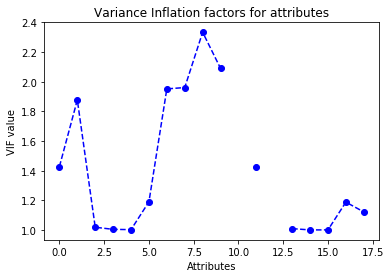

In [24]:
plt.plot(vif,'--bo')
plt.title('Variance Inflation factors for attributes')
plt.xlabel('Attributes')
plt.ylabel('VIF value')
vif

## As we can see, VIF is infinity for 'home/away' and 'type_of_shot', so we need to remove these attributes

## Solving problem of multicollinearity

In [25]:
X = np.delete(X, [10,12], axis = 1)
print('New X:', X.shape)

New X: (24429, 16)


In [26]:
X_columns

Index(['location_x', 'location_y', 'remaining_min', 'power_of_shot',
       'knockout_match', 'remaining_sec', 'distance_of_shot', 'area_of_shot',
       'shot_basics', 'range_of_shot', 'home/away', 'lat/lng', 'type_of_shot',
       'remaining_min.1', 'power_of_shot.1', 'knockout_match.1',
       'remaining_sec.1', 'distance_of_shot.1'],
      dtype='object')

# Dimensionality Reduction
## How many dimensions to keep?


In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=16)
pca.fit(X)
variance = pca.explained_variance_ratio_ #calculate variance ratios
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
print('Cumulative Variance with dimensions is: ')
var #cumulative sum of variance explained with [n] features
#X = pca.fit_transform(X)

Cumulative Variance with dimensions is: 


array([ 19.4,  28.4,  37. ,  43.9,  50.5,  56.9,  63.1,  69.2,  75.2,
        80.9,  86.2,  90.1,  93.8,  96.4,  98.5, 100.3])

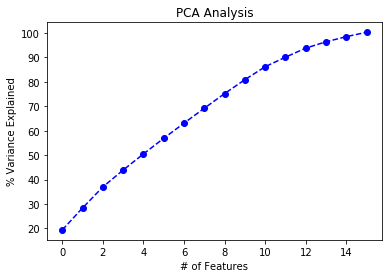

In [28]:
from sklearn import decomposition
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.plot(var, '--bo')



---


## In the above array we see that the first feature explains roughly 19% of the variance within our data set while the first two explain 28 and so on. If we employ 14 features we capture 96.4% of the variance within the dataset, thus we gain very little by implementing an additional feature.


---






In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=14)
X = pca.fit_transform(X)
print('X shape',X.shape)

X shape (24429, 14)


# Again Train:Test split

In [29]:
from sklearn import metrics 
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1) 
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19543, 16), (4886, 16), (19543,), (4886,))

## 1. Linear Regression

In [30]:
from sklearn import linear_model
# create linear regression object 
reg = linear_model.LinearRegression()

#reg = linear_model.Ridge()   # Regulizer to prevent overfitting if any # Extra term (lambda * ((Slope)^2 + (Attr1)^2+ Attr2^2 +......) is used in loss function
# lambda is determined using cross validation
# Introduces Bias in model which reduces variance and hence be a good option to prevent overfitting
# train the model using the training sets 
reg.fit(X_train, y_train) 

y_pred = reg.predict(X_test)


mse(y_test, y_pred)

0.23842306492589543

## 2. Logistic regression

In [31]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(multi_class = 'ovr', max_iter = 100, solver = 'saga').fit(X_train, y_train) ## ovr = one vs rest -> binary output
y_pred = clf.predict(X_test)
mse(y_test, y_pred)                          

0.40912812116250513

### 3 SVM Regressor

In [32]:
from sklearn.svm import SVR
clf = SVR(gamma='scale', C=1.0, epsilon=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test) 
mse(y_test, y_pred)

0.2645925334645902

## 4. KNN Regressor

In [33]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=30)
neigh.fit(X_train, y_train) 

y_pred = neigh.predict(X_test)
#len(y_pred), len(y_pred_proba), len(y_test)
e = mse(y_test, y_pred)
print(e)

0.24630213307863738


## 5. Decision Tree (Regressor)

In [34]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
mse(y_test, y_pred)

0.4621878837494883

## 6. Random Forest Regressor

In [35]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=100, max_depth=5,random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mse(y_test, y_pred)

0.23644102191519825

# 6. XGBoost Regressor

In [36]:
from xgboost import XGBRegressor
clf = XGBRegressor()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mse(y_test, y_pred)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:51:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.23673319623905173

# 7. Artificial Neural Network 

In [0]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation
#Using Relu activation, and Adam optimizer, 50 epochs
#def best_model(X_train,y_train,X_test,y_test,X_test_ZS):

def best_model(X_train,y_train,X_test,y_test):

  model = Sequential()
  model.add(Dense(18, input_dim=16 ,activation='relu'))
  #model.add(Dense(6,  activation='relu'))
  #model.add(Dense(15,  activation='relu'))
  model.add(Dense(10,  activation='relu'))
  model.add(Dense(5,  activation='relu'))
  model.add(Dense(2,  activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='mean_squared_error', optimizer= 'adam',metrics=['accuracy'])
  model.summary()
  # Train model
  history = model.fit(X_train, y_train, nb_epoch=50, batch_size=20,  verbose=1)
  # Print Accuracy
  scores = model.evaluate(X_test, y_test) 
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  #train:test=0.10 
  #pred_new=model.predict(X_test_ZS)  
  #return pred_new

In [40]:
pred_new = best_model(X_train, y_train, X_test, y_test)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 18)                306       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                190       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 12        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 3         
Total params: 566
Trainable params: 566
Non-trainable params: 0
_________________________________________________________________



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Epoch 1/50
19543/19543 [==============================] - 10s 516us/step - loss: 0.2422 - acc: 0.5783
Epoch 2/50
19543/19543 [==============================] - 5s 232us/step - loss: 0.2392 - acc: 0.5972
Epoch 3/50
19543/19543 [==============================] - 5s 251us/step - loss: 0.2381 - acc: 0.6005
Epoch 4/50
19543/19543 [==============================] - 5s 236us/step - loss: 0.2373 - acc: 0.6028
Epoch 5/50
19543/19543 [==============================] - 5s 240us/step - loss: 0.2366 - acc: 0.6044
Epoch 6/50
19543/19543 [==============================] - 5s 233us/step - loss: 0.2359 - acc: 0.6049
Epoch 7/50
19543/19543 [==============================] - 5s 246us/step - loss: 0.2356 - acc: 0.6060
Epoch 8/50
19543/19543 [==============================] - 5s 240us/step - loss: 0.2350 - acc: 0.6089
Epoch 9/50
19543/19543 [==============================] - 5s 234us/step - loss: 0.2346 - acc: 0.6078
Epoch 10/50
19543/19543 [==============================] - 5s 232us/step - loss: 0.2342 -